<H1>Stratégie Envelope</H1>
Indicateurs: Envelope + SMA<br>
SEG

In [1]:
# Modules standards
import sys
sys.path.append('../../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Modules perso
from utilities.strategies import SaEnvelope
from utilities.data_manager import ExchangeDataManager
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, plot_bar_by_month
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation

In [ ]:
# Chargement de data dans un dataframe
exchange_name = "binance"
pair = "BTC/USDT"
coin = pair.split('/')[0]
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)

<H2>Backtest</H2>

╒═════════════════════════════╤══════════════════════════════════════╕
│ Résultats backtest          │ BTC/USDT(1h)                         │
╞═════════════════════════════╪══════════════════════════════════════╡
│ Période                     │ 01.01.2019 -> 17.01.2024             │
│ Portefeuille initial        │ 1,000.00 $                           │
│                             │                                      │
│ Portefeuille final          │ 3,322.98 $                           │
│ Performance vs US dollar    │ 232.30 %                             │
│ Pire Drawdown T|D           │ -14.49% | -22.88%                    │
│ Buy and hold performance    │ 1064.55 %                            │
│ Performance vs buy and hold │ -71.47 %                             │
│ Nombre total de trades      │ 95                                   │
│ Sharpe Ratio                │ 1.25                                 │
│ Global Win rate             │ 81.05 %                              │
│ Prof

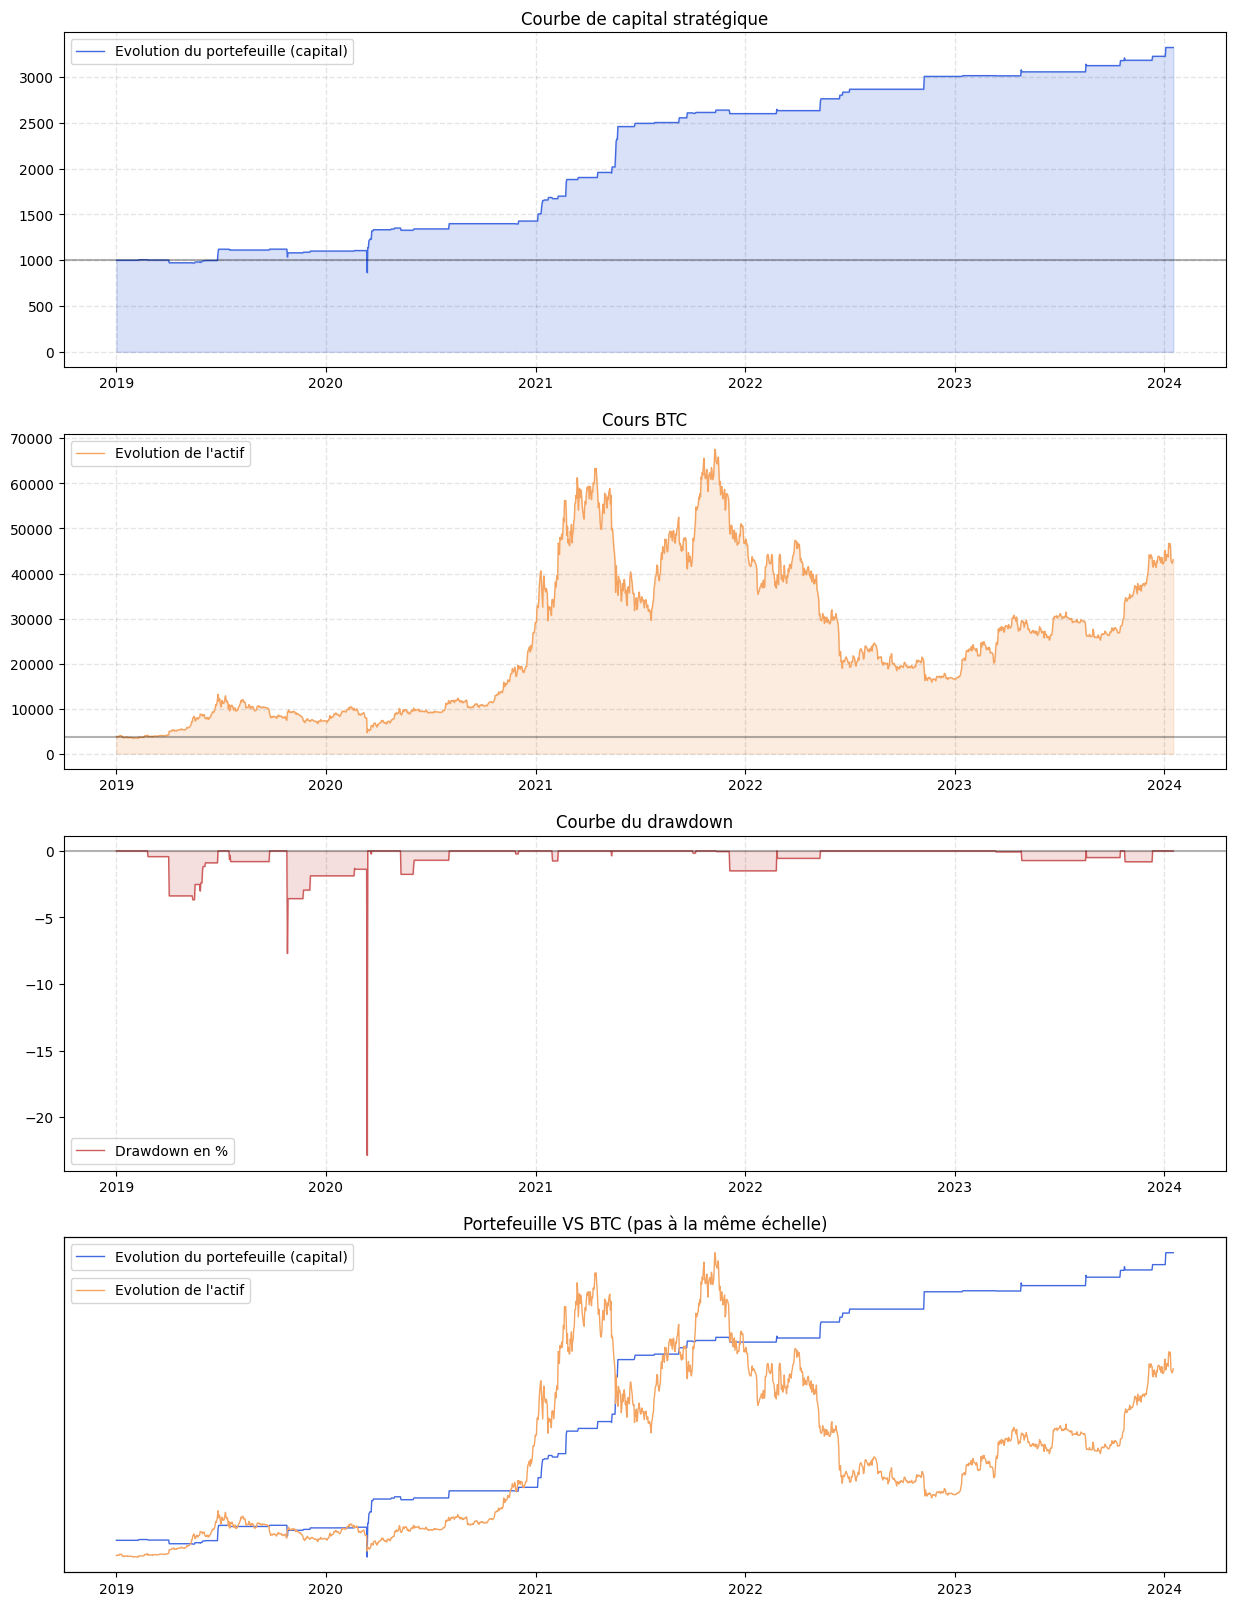

In [13]:
# Paramètres à modifier pour le backtest
# strat = SaEnvelope( # BTC
#     df = df.loc["2019":],
#     type=["long", "short"],
#     ma_base_window=7,
#     envelopes=[0.07, 0.1, 0.15],
#     src="close",
# )
strat = SaEnvelope( # ETH
    df = df.loc["2019":],
    type=["long", "short"],
    ma_base_window=6,
    envelopes=[0.07, 0.09, 0.11],
    src="close",
)
# strat = SaEnvelope( # ADA EGLD
#     df = df.loc["2019":],
#     type=["long", "short"],
#     ma_base_window=8,
#     envelopes=[0.06, 0.07, 0.08, 0.1],
#     src="close",
# )
# strat = SaEnvelope( # KSM OCEAN REN BAR
#     df = df.loc["2019":],
#     type=["long", "short"],
#     ma_base_window=5,
#     envelopes=[0.07, 0.1, 0.15, 0.2],
#     src="close",
# )

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'], pair=pair, tf=tf)
plot_wallet_vs_asset(df_days=df_days, pair=pair)

<H2>Performance par mois et année</H2>

----- 2019 Performances cumulées: 10.03% --


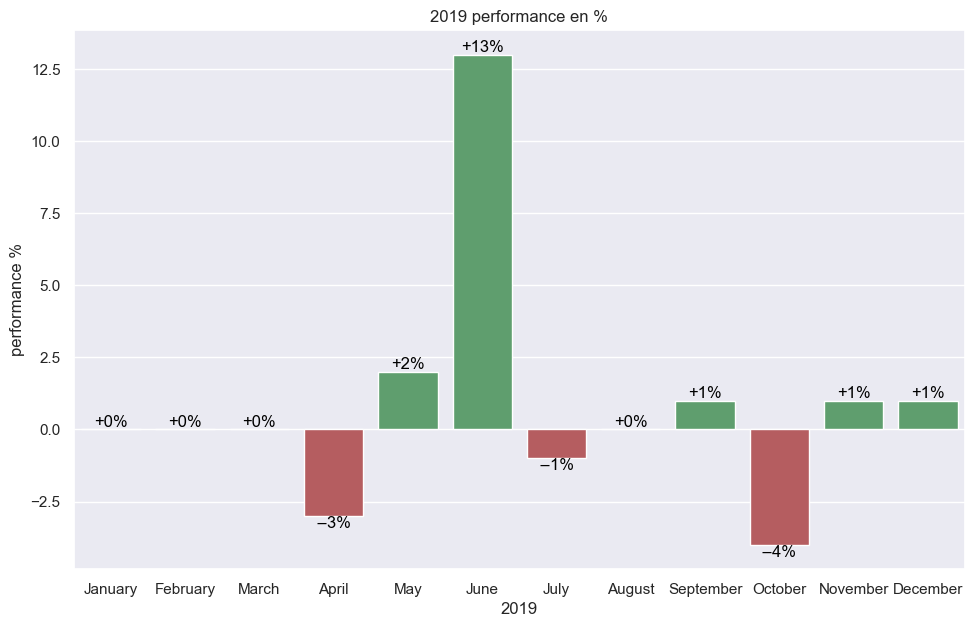

----- 2020 Performances cumulées: 29.79% --


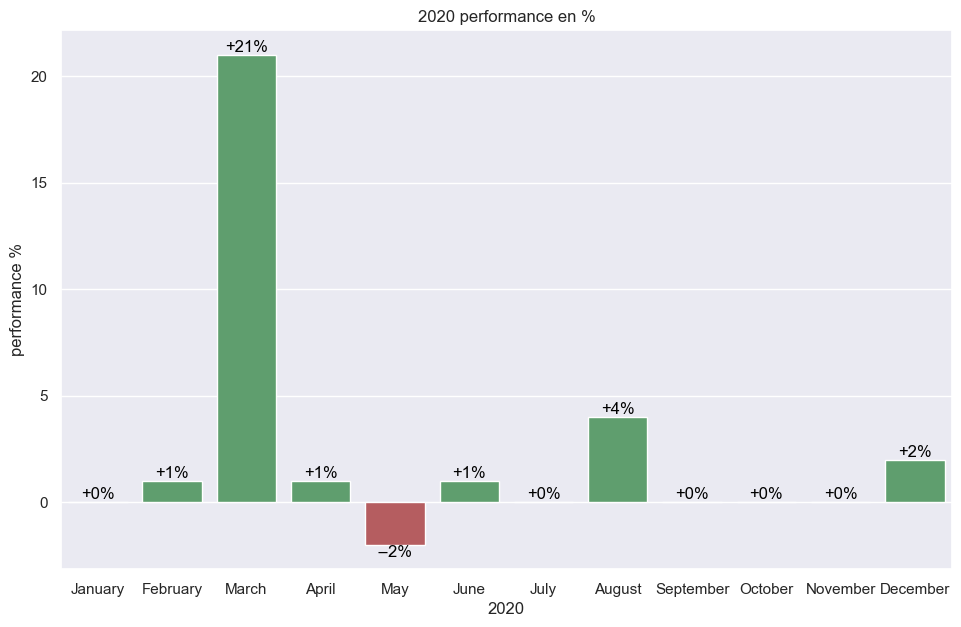

----- 2021 Performances cumulées: 82.13% --


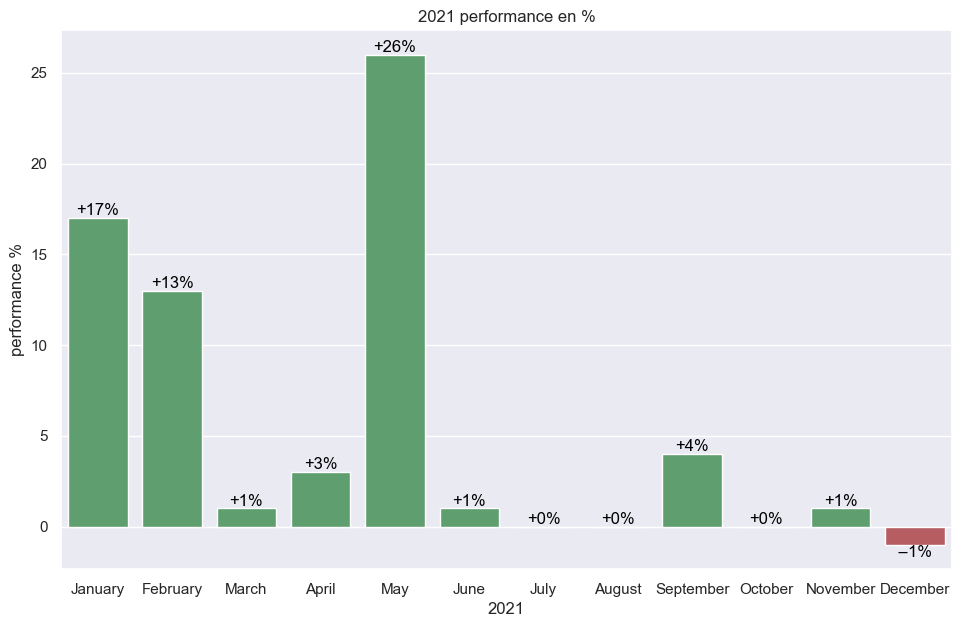

----- 2022 Performances cumulées: 15.62% --


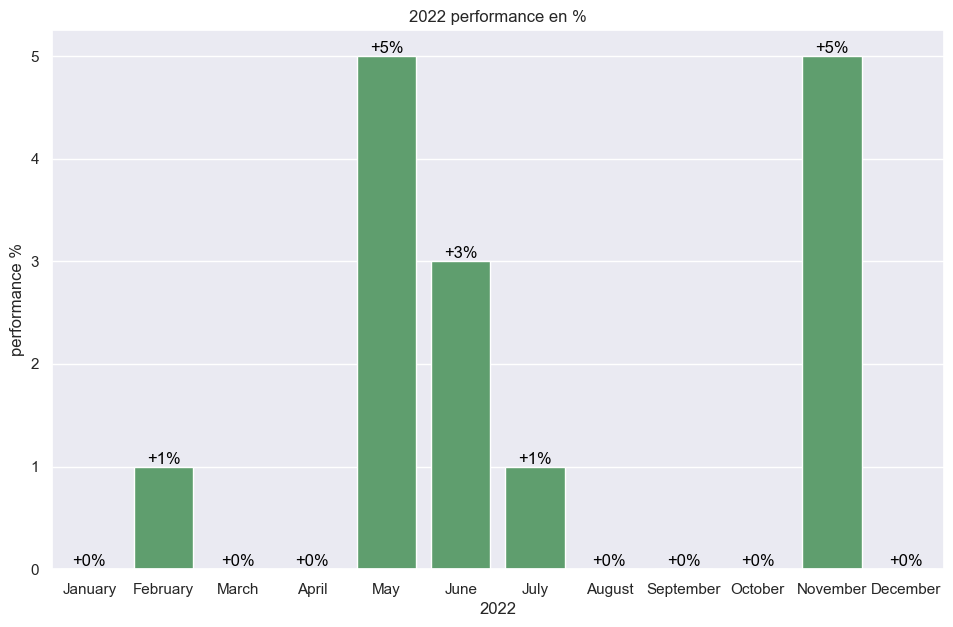

----- 2023 Performances cumulées: 7.3% --


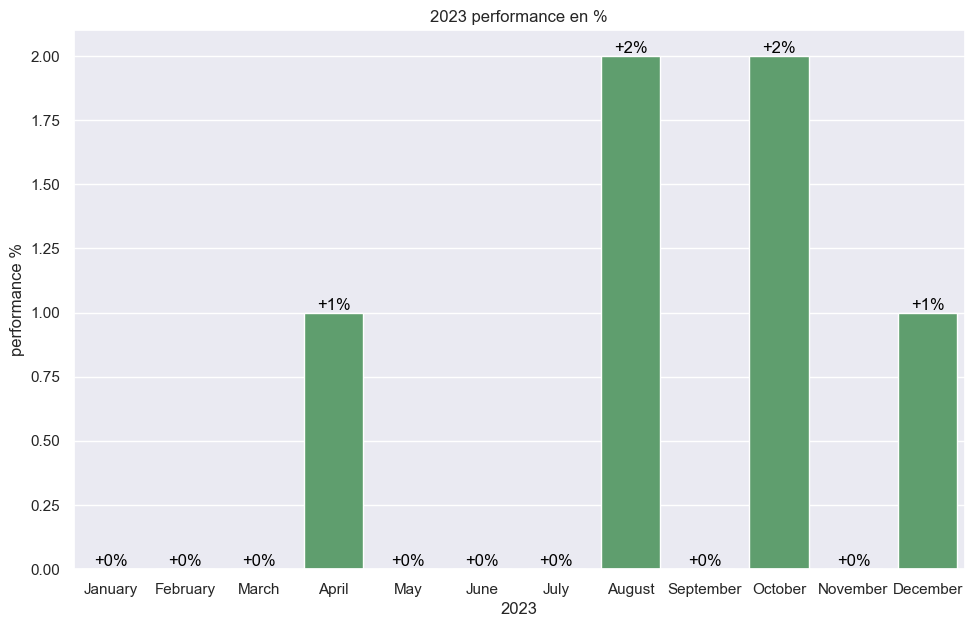

----- 2024 Performances cumulées: 2.98% --


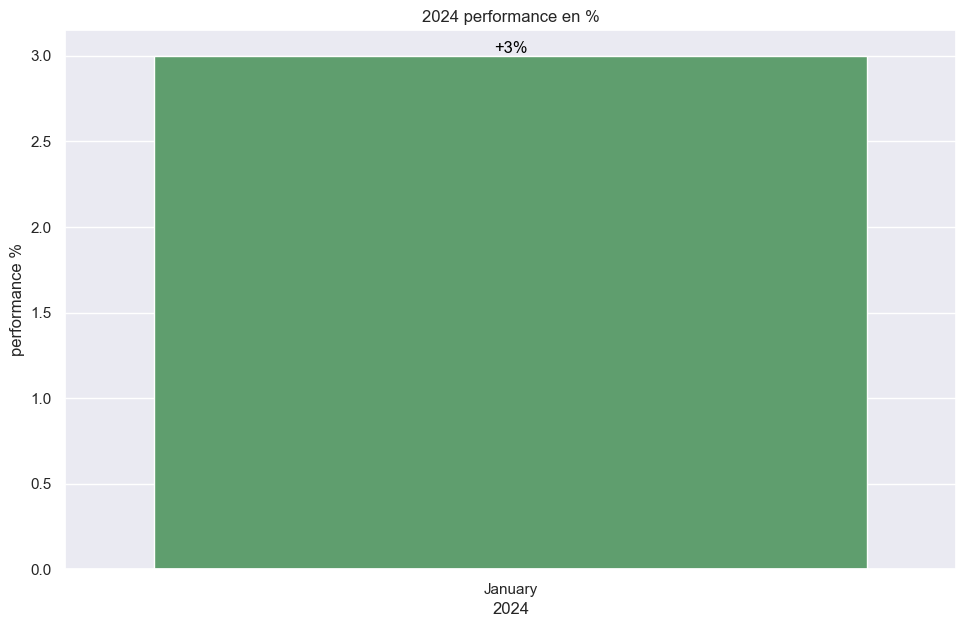

In [14]:
plot_bar_by_month(df_days)

<H2>Courbe de surapprentissage</H2>

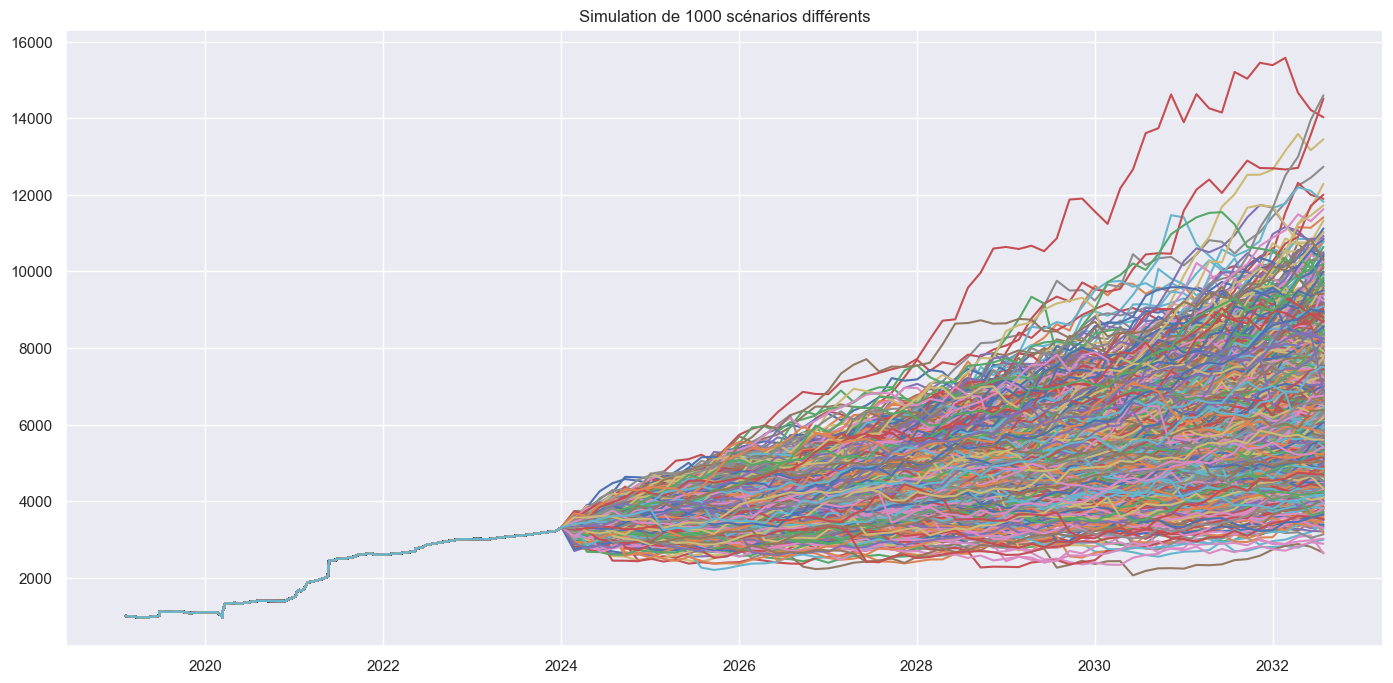

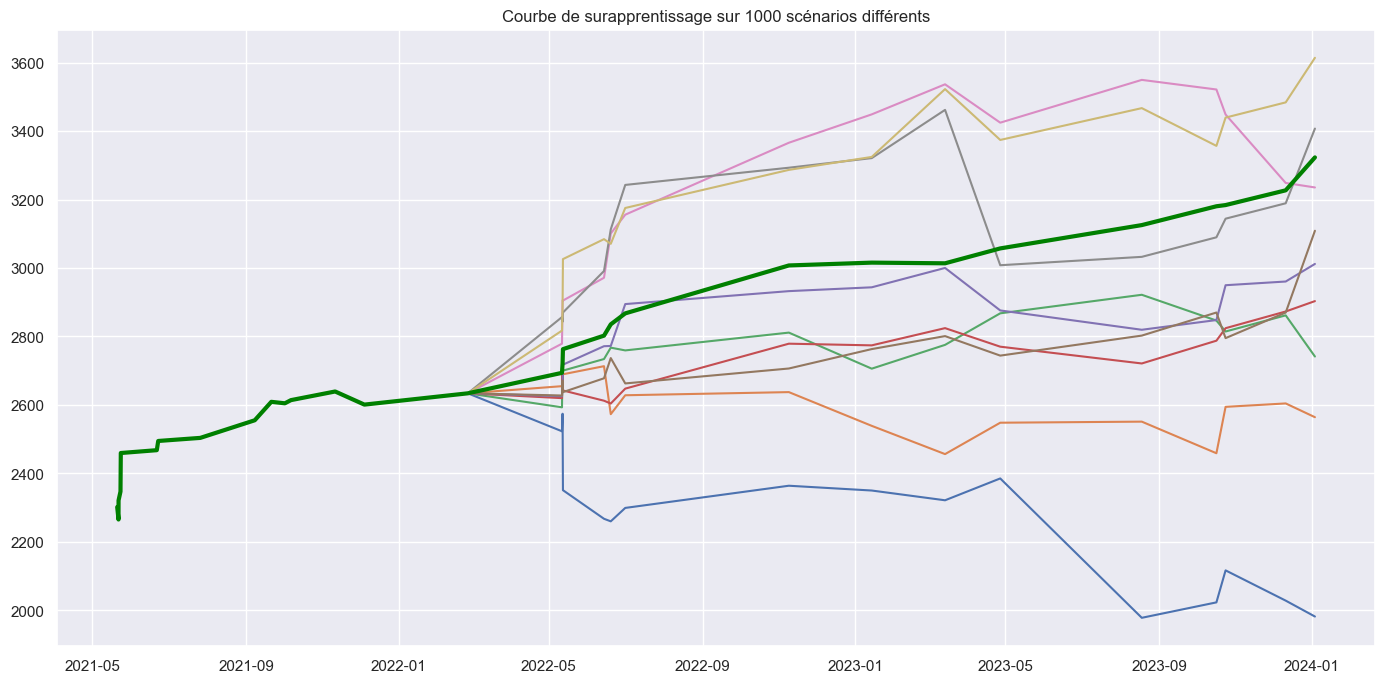

In [15]:
# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
# Séparation des échantillons en train et en test - Méthode de Monte Carlo (Loi normale)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-05-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)

<H2>Optimisation des paramètres</H2>

<h3>Hyperopt</h3>

In [16]:
# A déclarer avant l'optimisation pour avoir les graphiques sans avoir à lancer le module Hyperopt
from typing import List
import numpy as np
from hyperopt import hp

range_envelope_1 = np.arange(0.03, 0.11, 0.01)
range_envelope_1 = [round(val, 2) for val in range_envelope_1]
range_envelope_2 = np.arange(0.05, 0.12, 0.01)
range_envelope_2 = [round(val, 2) for val in range_envelope_2]
range_envelope_3 = np.arange(0.06, 0.15, 0.01)
range_envelope_3 = [round(val, 2) for val in range_envelope_3]
range_envelope_4 = np.arange(0.08, 0.2, 0.01)
range_envelope_4 = [round(val, 2) for val in range_envelope_4]

# Espace de recherche des hyperparamètres avec contraintes
index_np_arrange =4
space = {
    'ma_base_window': hp.choice('ma_base_window', np.arange(index_np_arrange, 10, dtype=int)),  # 4 à 9
    'envelopes': [
        hp.choice('envelope_1', range_envelope_1),                                              # 0.03 à 0.1
        hp.choice('envelope_2', range_envelope_2),                                              # 0.05 à 0.12
        hp.choice('envelope_3', range_envelope_3),                                              # 0.07 à 0.15
        hp.choice('envelope_4', range_envelope_4),                                              # 0.09 à 0.2
    ],
}

In [45]:
# Hyperopt
from hyperopt import fmin, Trials, tpe
from concurrent.futures import ThreadPoolExecutor
import pickle

def objective(params):
    ma_base_window = int(params['ma_base_window'])
    envelopes = params['envelopes']

    strat = SaEnvelope(
        df=df.loc["2019":],
        type=["long", "short"],
        ma_base_window=ma_base_window,
        envelopes=envelopes,
        src="close",
    )

    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

    # Métriques à optimiser
    wallet_metric = bt_result["wallet"]
    sharpe_ratio_metric = bt_result["sharpe_ratio"]
    weight_wallet = 0.7         # Poids pour le wallet final
    weight_sharpe_ratio = 0.3   # Poids pour le Sharpe Ratio

    # Fonction de perte combinée
    combined_loss = -(weight_wallet * wallet_metric + weight_sharpe_ratio * sharpe_ratio_metric)

    return combined_loss

max_evals = 500  # max_evals=5 pour test rapide.
with ThreadPoolExecutor() as executor:
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)    

# Sauvegarde des résultats dans un fichier pickle
if max_evals >= 50:
    with open('hyperopt/'+ coin + '_' + str(max_evals) + '_envelope.pkl', 'wb') as f:
        pickle.dump(trials, f)

# Afficher les meilleurs hyperparamètres trouvés
best_ma_base_window = best['ma_base_window'] + index_np_arrange
best_envelopes_indices = [best['envelope_1'], best['envelope_2'], best['envelope_3'], best['envelope_4']]
best_envelopes_values = [
        range_envelope_1[best_envelopes_indices[0]],
        range_envelope_2[best_envelopes_indices[1]],
        range_envelope_3[best_envelopes_indices[2]],
        range_envelope_4[best_envelopes_indices[3]],
]

print(f"Best ma_base_window: {best_ma_base_window}")
print(f"Best envelopes: {best_envelopes_values}")

100%|██████████| 500/500 [07:47<00:00,  1.07trial/s, best loss: -15743.968593293335]
Best ma_base_window: 6
Best envelopes: [0.08, 0.08, 0.09, 0.09]


In [46]:
# Backtest rapide avec les meilleures paramètres
import pickle

file_pkl = 'hyperopt/'+ coin + '_' + str(max_evals) + '_envelope.pkl'
# file_pkl = 'hyperopt/BTC_1000_envelope.pkl'

with open(file_pkl, 'rb') as f:
    trials = pickle.load(f)

index_np_arrange =4
best_trial = min(trials, key=lambda x: x['result']['loss'])
best_hyperparams = best_trial['misc']['vals']
best_ma_base_window = int(best_hyperparams['ma_base_window'][0]) + index_np_arrange
best_envelopes_indices = [int(best_hyperparams['envelope_1'][0]), int(best_hyperparams['envelope_2'][0]), int(best_hyperparams['envelope_3'][0]), int(best_hyperparams['envelope_4'][0])]
best_envelopes = [
    range_envelope_1[best_envelopes_indices[0]],
    range_envelope_2[best_envelopes_indices[1]],
    range_envelope_3[best_envelopes_indices[2]],
    range_envelope_4[best_envelopes_indices[3]],
]

# Utiliser les meilleurs paramètres pour obtenir le résultat final
best_strat = SaEnvelope(
    df=df.loc["2019":],
    type=["long", "short"],
    ma_base_window=best_ma_base_window,
    envelopes=best_envelopes,
    src="close",
)

best_strat.populate_indicators()
best_strat.populate_buy_sell()
best_result = best_strat.run_backtest(initial_wallet=1000, leverage=1)

# Afficher le wallet et le sharpe_ratio des meilleures paramètres
print(f"Pair:                 {pair}")
print(f"Best ma_base_window:  {best_ma_base_window}")
print(f"Best envelopes:       {best_envelopes}")
print(f"Best Wallet:          {best_result['wallet']}")
print(f"Best Sharpe ratio:    {best_result['sharpe_ratio']}")

Pair:                 ETH/USDT
Best ma_base_window:  6
Best envelopes:       [0.08, 0.08, 0.09, 0.09]
Best Wallet:          22490.59766688411
Best Sharpe ratio:    1.8340882481984195


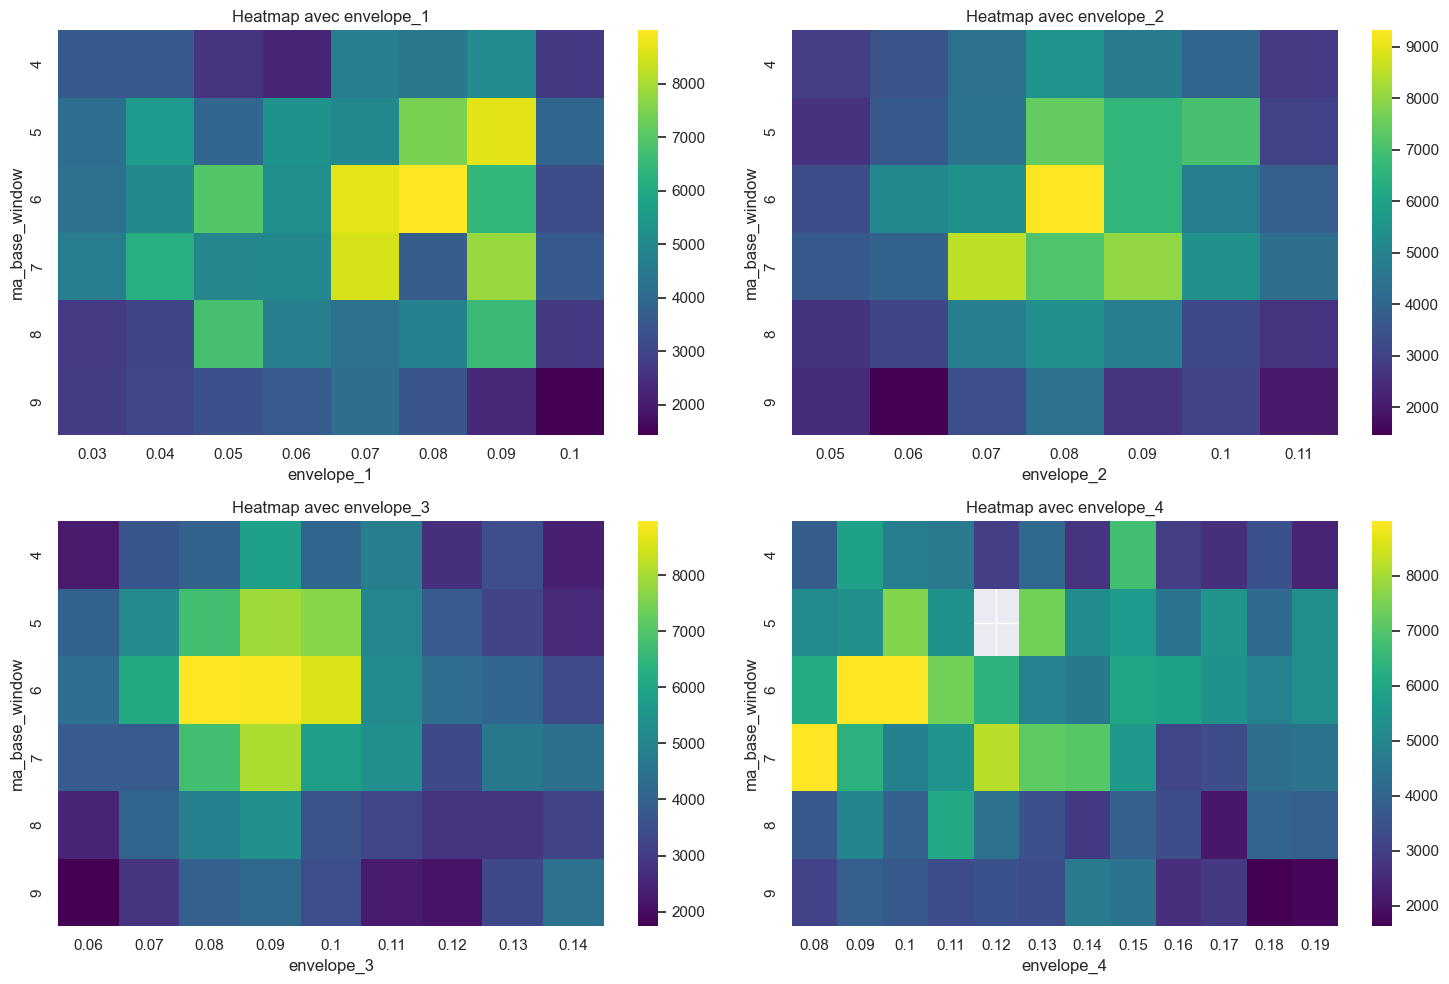

In [47]:
# Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire les informations des Trials
results_df = pd.DataFrame({
    'ma_base_window': [int(trial['misc']['vals']['ma_base_window'][0]) + index_np_arrange for trial in trials.trials],
    'envelope_1': [trial['misc']['vals']['envelope_1'][0] for trial in trials.trials],
    'envelope_2': [trial['misc']['vals']['envelope_2'][0] for trial in trials.trials],
    'envelope_3': [trial['misc']['vals']['envelope_3'][0] for trial in trials.trials],
    'envelope_4': [trial['misc']['vals']['envelope_4'][0] for trial in trials.trials],
    'score': [-trial['result']['loss'] for trial in trials.trials]
})

# Convertir les indices des enveloppes en valeurs réelles
results_df['envelope_1'] = results_df['envelope_1'].apply(lambda idx: range_envelope_1[idx])
results_df['envelope_2'] = results_df['envelope_2'].apply(lambda idx: range_envelope_2[idx])
results_df['envelope_3'] = results_df['envelope_3'].apply(lambda idx: range_envelope_3[idx])
results_df['envelope_4'] = results_df['envelope_4'].apply(lambda idx: range_envelope_4[idx])

# Créer une figure avec une grille de sous-graphiques (2 lignes, 2 colonnes)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Liste des enveloppes
envelopes = ['envelope_1', 'envelope_2', 'envelope_3', 'envelope_4']

# Tracer une heatmap par enveloppe
for i, envelope in enumerate(envelopes):
    pivot_table = results_df.pivot_table(index='ma_base_window', columns=envelope, values='score', aggfunc='mean')
    sns.heatmap(pivot_table, annot=False, fmt=".2f", cmap="viridis", ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Heatmap avec {envelope}')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


In [48]:
# Exploration 3D
import plotly.express as px

# Extraire les informations des Trials
results_df = pd.DataFrame({
    'ma_base_window': [trial['misc']['vals']['ma_base_window'][0] + index_np_arrange for trial in trials.trials],
    'envelope_1': [round(trial['misc']['vals']['envelope_1'][0], 2) for trial in trials.trials],
    'envelope_2': [round(trial['misc']['vals']['envelope_2'][0], 2) for trial in trials.trials],
    'envelope_3': [round(trial['misc']['vals']['envelope_3'][0], 2) for trial in trials.trials],
    'envelope_4': [round(trial['misc']['vals']['envelope_4'][0], 2) for trial in trials.trials],
    'score': [-trial['result']['loss'] for trial in trials.trials]
})

# Convertir les indices des enveloppes en valeurs réelles
results_df['envelope_1'] = results_df['envelope_1'].apply(lambda idx: range_envelope_1[idx])
results_df['envelope_2'] = results_df['envelope_2'].apply(lambda idx: range_envelope_2[idx])
results_df['envelope_3'] = results_df['envelope_3'].apply(lambda idx: range_envelope_3[idx])
results_df['envelope_4'] = results_df['envelope_4'].apply(lambda idx: range_envelope_4[idx])

# Créer une heatmap interactive avec Plotly
fig = px.scatter_3d(results_df,
                    x='envelope_1',
                    y='envelope_2',
                    z='envelope_3',
                    color='score',
                    size='ma_base_window',
                    labels={'envelope_1': 'Envelope 1', 'envelope_2': 'Envelope 2', 'envelope_3': 'Envelope 3', 'envelope_4': 'Envelope 4'},
                    title='Optimisation des Paramètres',
                    opacity=0.7,
                    hover_name='score')

# Augmenter la hauteur de la heatmap
fig.update_layout(scene=dict(aspectmode='data'),
                  margin=dict(r=0, l=0, b=0, t=0),
                  height=600, width=1000 )

# Afficher la figure interactive
fig.show()


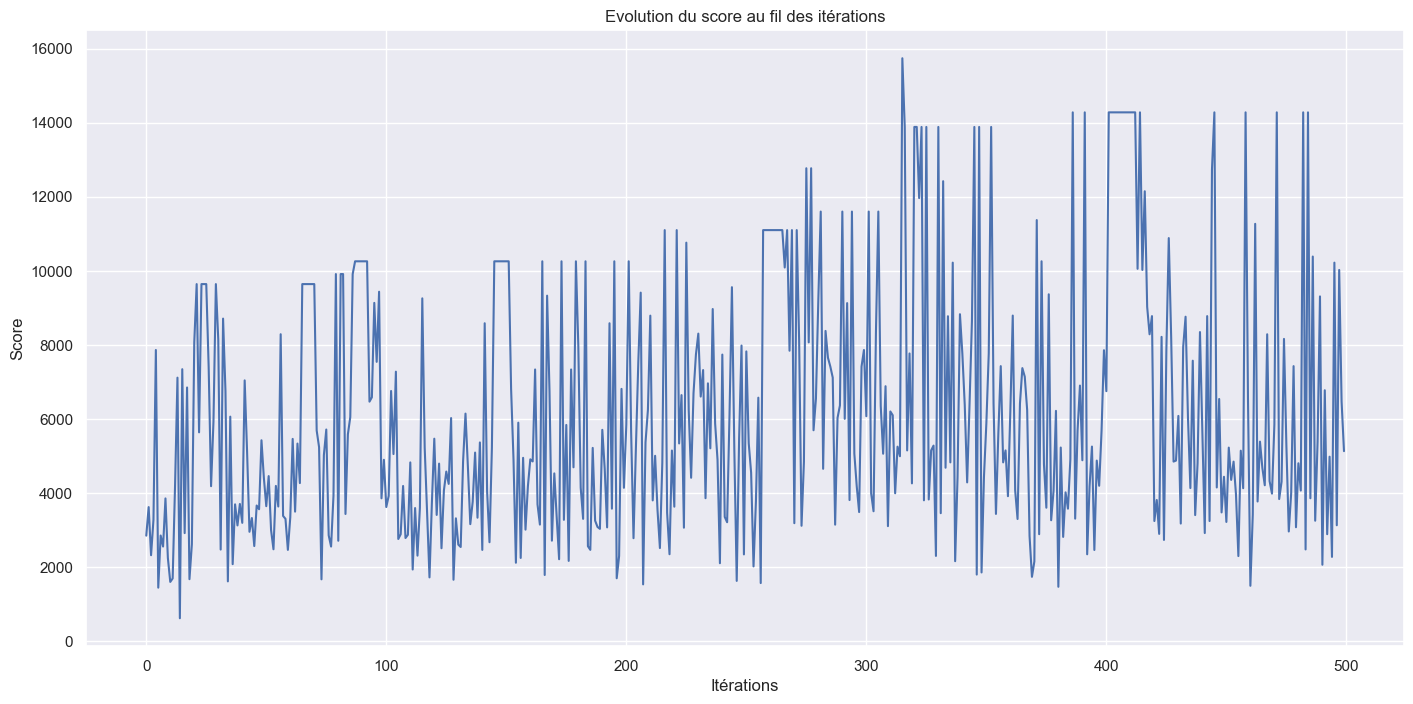

In [49]:
# Evolution du score au fil des itérations
import matplotlib.pyplot as plt

# Récupérer les résultats des évaluations
results = [-trial['result']['loss'] for trial in trials.trials]

# Afficher l'évolution des scores au fil des itérations
plt.plot(results)
plt.xlabel('Itérations')
plt.ylabel('Score')
plt.title('Evolution du score au fil des itérations')
plt.show()

Perte minimale:  622.1600832560077


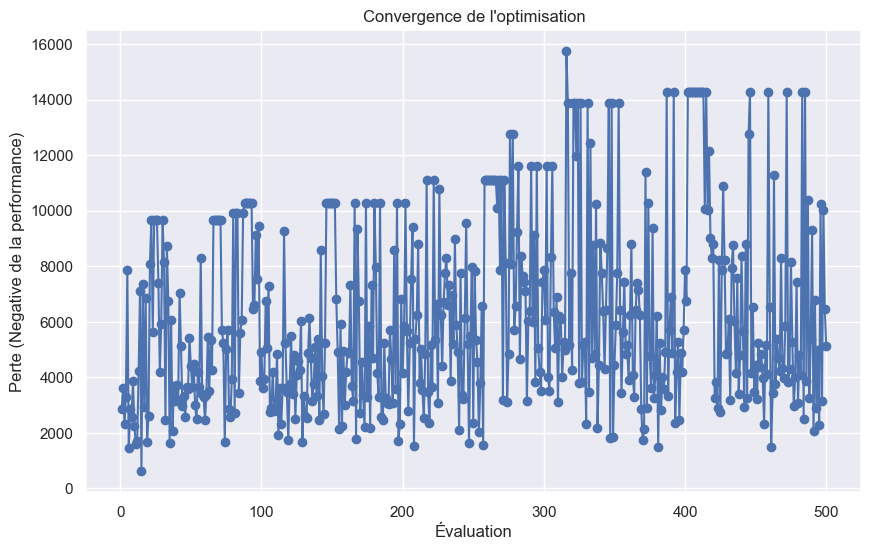

In [51]:
# Extraire les performances au fil des évaluations
losses = [-trial.get('result', {}).get('loss', None) for trial in trials.trials]
print("Perte minimale: ", np.min(losses))

# Créer le DataFrame de convergence
convergence_df = pd.DataFrame({
    'Evaluation': range(1, len(losses) + 1),
    'Perte': losses
})

# print("Pertes au fil des évaluations:", losses)

plt.figure(figsize=(10, 6))
plt.plot(convergence_df['Evaluation'], convergence_df['Perte'], marker='o', linestyle='-', color='b')
plt.title('Convergence de l\'optimisation')
plt.xlabel('Évaluation')
plt.ylabel('Perte (Negative de la performance)')
plt.show()

<H3>Optuna</H3>

In [4]:
import optuna
from functools import partial

def create_default_params():
    default_params = {}
    for pair in pairs:
        default_params[pair] = {
            "src": "close",
            "ma_base_window": 5,
            "envelopes": [],
            "size": 0.01
        }
    return default_params

def optimize(trial):
    ma_base_window = trial.suggest_int("ma_base_window", 3, 9)
    envelopes = [
        trial.suggest_float(f"e{i+1}", low, high, step=0.01)
        for i, (low, high) in enumerate([(0.02, 0.1), (0.05, 0.13), (0.07, 0.15), (0.08, 0.21)])
    ]
    
    strat = SaEnvelope(
        df=df.loc["2019":],
        type=["long", "short"],
        ma_base_window=ma_base_window,
        envelopes=envelopes,
        src='close'
    )
    
    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
    
    # Combinaison pondérée du Sharpe ratio et du portefeuille
    objective_value = 0.3 * bt_result["sharpe_ratio"] + 0.7 * bt_result["wallet"]
    
    return objective_value

study = optuna.create_study(direction="maximize", storage="sqlite:///envelope.db", study_name=pair, load_if_exists=True)
study.optimize(partial(optimize), n_trials=5)

# Test final avec les meilleurs paramètres
best_params = study.best_params

new_strat = SaEnvelope(
    df=df,
    type=["long", "short"],
    ma_base_window=best_params['ma_base_window'],
    envelopes=[best_params[f'e{i}'] for i in range(1, len(best_params))],
    src='close'
)

new_strat.populate_indicators()
new_strat.populate_buy_sell()

bt_result = new_strat.run_backtest(initial_wallet=1000, leverage=1)

print(pair)
print("Valeur finale du portefeuille:   ", round(bt_result["wallet"],2), '$')
print("Ratio de Sharpe final:           ", round(bt_result["sharpe_ratio"],2))
print("Meilleur Score:                  ", round(study.best_value,2))
print("Paramètres optimaux: ", study.best_params)

[I 2024-01-17 18:57:35,356] Using an existing study with name 'BTC/USDT' instead of creating a new one.
[I 2024-01-17 18:57:36,348] Trial 110 finished with value: 3192.3572294683663 and parameters: {'ma_base_window': 6, 'e1': 0.06, 'e2': 0.060000000000000005, 'e3': 0.07, 'e4': 0.08}. Best is trial 110 with value: 3192.3572294683663.
[I 2024-01-17 18:57:37,319] Trial 111 finished with value: 3192.3572294683663 and parameters: {'ma_base_window': 6, 'e1': 0.06, 'e2': 0.060000000000000005, 'e3': 0.07, 'e4': 0.08}. Best is trial 110 with value: 3192.3572294683663.
[I 2024-01-17 18:57:38,207] Trial 112 finished with value: 3192.3572294683663 and parameters: {'ma_base_window': 6, 'e1': 0.06, 'e2': 0.060000000000000005, 'e3': 0.07, 'e4': 0.08}. Best is trial 110 with value: 3192.3572294683663.
[I 2024-01-17 18:57:39,169] Trial 113 finished with value: 3192.3572294683663 and parameters: {'ma_base_window': 6, 'e1': 0.06, 'e2': 0.060000000000000005, 'e3': 0.07, 'e4': 0.08}. Best is trial 110 with

BTC/USDT
Valeur finale du portefeuille:    44122.73 $
Ratio de Sharpe final:            2.06
Meilleur Score:                   3192.36
Paramètres optimaux:  {'ma_base_window': 6, 'e1': 0.06, 'e2': 0.060000000000000005, 'e3': 0.07, 'e4': 0.08}


In [5]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline


plot_optimization_history(study)

In [6]:
plot_contour(study)

In [7]:
plot_slice(study)

In [8]:
plot_param_importances(study)

In [9]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [10]:
plot_edf(study)

In [11]:
plot_rank(study)

C:\Users\jacks\AppData\Local\Temp\ipykernel_45644\3430271029.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



<H3>Manuel</H3>

In [ ]:
# Méthode classique par boucle (A terminer et a commenter)
import itertools
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time

start_time = time.time()

ma_base_window_values = list(range(3, 7))
envelopes_values = [
    [round(val1, 3), round(val2, 3), round(val3, 3)] 
    for val1, val2, val3 in itertools.product(
        [i * 0.02 for i in range(2, 8)], 
        [i * 0.02 for i in range(8, 14)], 
        [i * 0.02 for i in range(14, 20)]
    )
]

with ThreadPoolExecutor() as executor:
    def run_backtest(params):
        ma_base_window, envelopes = params
        current_strat = SaEnvelope(
            df=df.loc["2019-01-02":],
            type=["long", "short"],
            ma_base_window=ma_base_window,
            envelopes=envelopes,
            src="close",
        )

        current_strat.populate_indicators()
        current_strat.populate_buy_sell()
        current_result = current_strat.run_backtest(initial_wallet=1000, leverage=1)
        return {'params': {'ma_base_window': ma_base_window, 'envelopes': envelopes}, 'result': current_result}

    results = list(tqdm(executor.map(run_backtest, itertools.product(ma_base_window_values, envelopes_values)), total=len(ma_base_window_values)*len(envelopes_values)))

best_result = max(results, key=lambda x: x['result']['wallet'])

print("Best Parameters:", best_result['params'])
print("Best Performance (Final Wallet Value):", best_result['result']['wallet'])
print("Sharpe Ratio: ", best_result['result']['sharpe_ratio'])
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps de calcul total:", elapsed_time, "secondes")